In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.style.use('ggplot')
import seaborn as sns
import statistics

In [2]:
results = pd.read_csv("test_results/pg_duck_tpch_test_results.csv") 
test_name = "postgres_duck_db"

results = results.rename(columns={"Average": "Mean"})

In [3]:
print(len(results))
results.head()

88


,Data Type,Scaling Factor,Query Name,Query Number,Mean,Correct,Executed,Runs
0,SQL,1,Postgres,Query 1,6.370,True,Yes,"[6.4829206466674805, 6.112210273742676, 6.0885..."
1,SQL,1,Duck DB,Query 1,0.426,True,Yes,"[0.4917769432067871, 0.42227673530578613, 0.41..."
2,Pandas,1,Pandas Converted (Duck DB),Query 1,2.430,True,Yes,"[7.15959906578064, 1.510803461074829, 1.478646..."
3,Pandas,1,Pandas Converted (Postgres),Query 1,1.910,True,Yes,"[2.4505927562713623, 1.823503017425537, 1.7725..."
4,SQL,1,Postgres,Query 2,1.180,True,Yes,"[1.2991671562194824, 1.2142317295074463, 1.162..."


In [4]:
# Filter for Correct == True and Executed == Yes
results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(len(results))

88


In [5]:
# Sort Query Name column to in-order
def extract_number(name):
    return int(name.split(" ")[1])

results['Query Number'] = results.apply(lambda row : extract_number(row['Query Number']), axis = 1)
results = results.sort_values(['Query Number'])

# Fix the runs column
def fix_runs(runs):
    new_runs = list(str(str(runs)[1:-1]).split(","))
    for i in range(0, len(new_runs)):
        new_runs[i] = float(new_runs[i].strip())
    return new_runs

results['Runs'] = results.apply(lambda row : fix_runs(row['Runs']), axis = 1)

results['Median'] = results.apply(lambda row: statistics.median(sorted(row['Runs'])), axis = 1)

def ignore_first_mean(runs):
    return statistics.mean(runs[1:])

results['Mean_first'] = results.apply(lambda row : ignore_first_mean(row['Runs']), axis = 1)
results["Query Type"] = results["Query Name"]

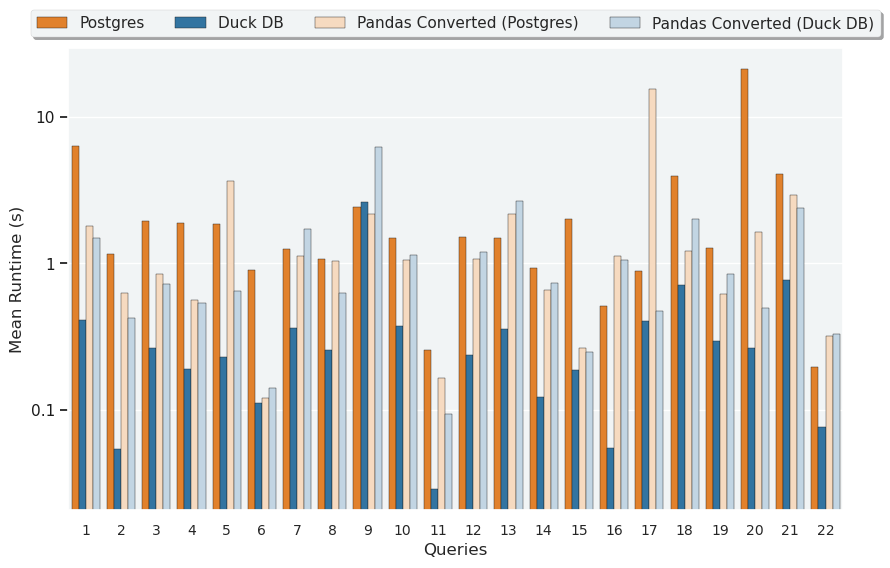

In [6]:
# plot with seaborn barplot
sns.set(rc={'figure.figsize':(10,6)})
background_color = '#f1f4f5'
sns.set(rc={'axes.facecolor':background_color})
plt.rcParams['patch.linewidth'] = 0.3
plt.rcParams['patch.edgecolor'] = 'k'

# The other colors are 70% tints of the original
# From: https://imagecolorpicker.com/color-code/
color = ['tab:orange','tab:blue','#ffd9b7', '#bcd6e9']
order = ["Postgres", "Duck DB", "Pandas Converted (Postgres)", "Pandas Converted (Duck DB)"]

ax = sns.barplot(data=results, x='Query Number', y='Mean_first', hue='Query Type',
                 palette=color, hue_order=order)

ax.set_yscale("log")
ax.set(xlabel='Queries', ylabel='Mean Runtime (s)')

# the non-logarithmic labels 
ticks = [0.1, 1, 10]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)

#set parameters for tick labels
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', direction="out", colors="k", left=True)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10),
          ncol=4, fancybox=True, shadow=True)

plt.savefig("analysis_results/" + str(test_name) + "_compare_queries.pdf", bbox_inches="tight")
plt.show()

In [93]:
# Number to show peformance of each, in comparison to each other

In [94]:
# This is old and no longer works
"""
# Make graph of change in runtimes
# Y: Run time, X: Run Number
# Line: Query Number
prev_colors = {}

fig, ax = plt.subplots()

for index, row in results.iterrows():
    if row["Data Type"] == "SQL":
        line_style = 'dashed'
        legend_info = None
    else:
        line_style = 'solid'
        legend_info = row["Query Name"]
    
    # Choose line color
    if prev_colors.get(row["Query Name"], None) == None:
        # Not in dataframe
        line = ax.plot(list(range(1, len(row["Runs"])+1)), row["Runs"], label=legend_info, linestyle=line_style)
        prev_colors[row["Query Name"]] = line[0].get_color()
    else:
        color_line = prev_colors[row["Query Name"]]
        ax.plot(list(range(1, len(row["Runs"])+1)), row["Runs"], label=legend_info, linestyle=line_style, color=color_line)

# Add extra info to legend
ax.plot([], [], " ", label=" "*5,)
ax.plot([], [], label="SQL", color="black", linestyle="dashed")
ax.plot([], [], label="Pandas", color="black", linestyle="solid")

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(1))

plt.title('Change in Execution Speed across Time')
plt.xlabel('Run Number')
plt.ylabel('Runtime, seconds (s)')
ax.legend(labelspacing=0.01)
plt.savefig("analysis_results/" + str(test_name) + "_compare_queries_exec_time.pdf")
plt.show()
"""

'\n# Make graph of change in runtimes\n# Y: Run time, X: Run Number\n# Line: Query Number\nprev_colors = {}\n\nfig, ax = plt.subplots()\n\nfor index, row in results.iterrows():\n    if row["Data Type"] == "SQL":\n        line_style = \'dashed\'\n        legend_info = None\n    else:\n        line_style = \'solid\'\n        legend_info = row["Query Name"]\n    \n    # Choose line color\n    if prev_colors.get(row["Query Name"], None) == None:\n        # Not in dataframe\n        line = ax.plot(list(range(1, len(row["Runs"])+1)), row["Runs"], label=legend_info, linestyle=line_style)\n        prev_colors[row["Query Name"]] = line[0].get_color()\n    else:\n        color_line = prev_colors[row["Query Name"]]\n        ax.plot(list(range(1, len(row["Runs"])+1)), row["Runs"], label=legend_info, linestyle=line_style, color=color_line)\n\n# Add extra info to legend\nax.plot([], [], " ", label=" "*5,)\nax.plot([], [], label="SQL", color="black", linestyle="dashed")\nax.plot([], [], label="Pandas